# Wprowadzenie
Tym razem spróbujemy zastosować algorytm **QSVC (Quantum Support Vector Classifier)**, czyli kwantową wersję klasycznego algorytmu SVM. Zastosowanie komputerów kwantowych pozwala na wykorzystanie bardziej złożonych funkcji jądra, co może poprawić dokładność klasyfikacji dla niektórych typów danych.

Documentation to QSVC: 

https://qiskit-community.github.io/qiskit-machine-learning/tutorials/03_quantum_kernel.html

https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html

## Zadanie 1: Przygotowanie danych
Najpierw przygotujemy dane, które będą wykorzystane w zadaniu. Korzystamy z zestawu danych typu "księżyce", który generuje dwa klasyfikowalne zbiory punktów, ale ich kształt nie jest liniowy.

In [1]:
from qiskit_algorithms.utils import algorithm_globals
from matplotlib import pyplot as plt

random_seed = 1234 # setting randomness seed 
algorithm_globals.random_seed = random_seed

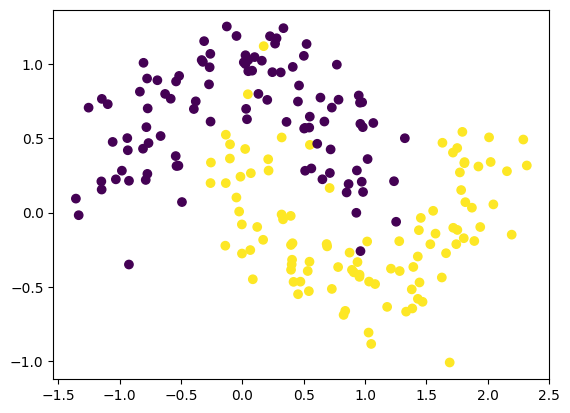

In [4]:
%matplotlib inline

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=200, noise=.2, random_state=random_seed)

plt.scatter(X[:,0], X[:,1], c=y)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_seed)
X.shape, X_train.shape, X_test.shape

((200, 2), (160, 2), (40, 2))

## Zadanie 2: Quantum Feature Map
W tym kroku musimy przygotować kwantową reprezentację danych. Użyjemy tutaj mapy cech opartej na kwantowych bramkach. Ten krok pozwala na odwzorowanie danych w przestrzeni kwantowej, gdzie łatwiej jest znaleźć granice decyzyjne.

**Zadanie: Zaimplementujcie mapę cech kwantowych i obliczcie macierz jądra dla danych.**

Documentation for ZZFeatureMap: https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap

Documentation for ComputeUncompute: https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.state_fidelities.ComputeUncompute.html#computeuncompute

Documentation for FidelityQuantumKernel: https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html

In [16]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.visualization import circuit_drawer

C:\Users\jozek\AppData\Local\Temp\ipykernel_13320\374759964.py:9: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler()


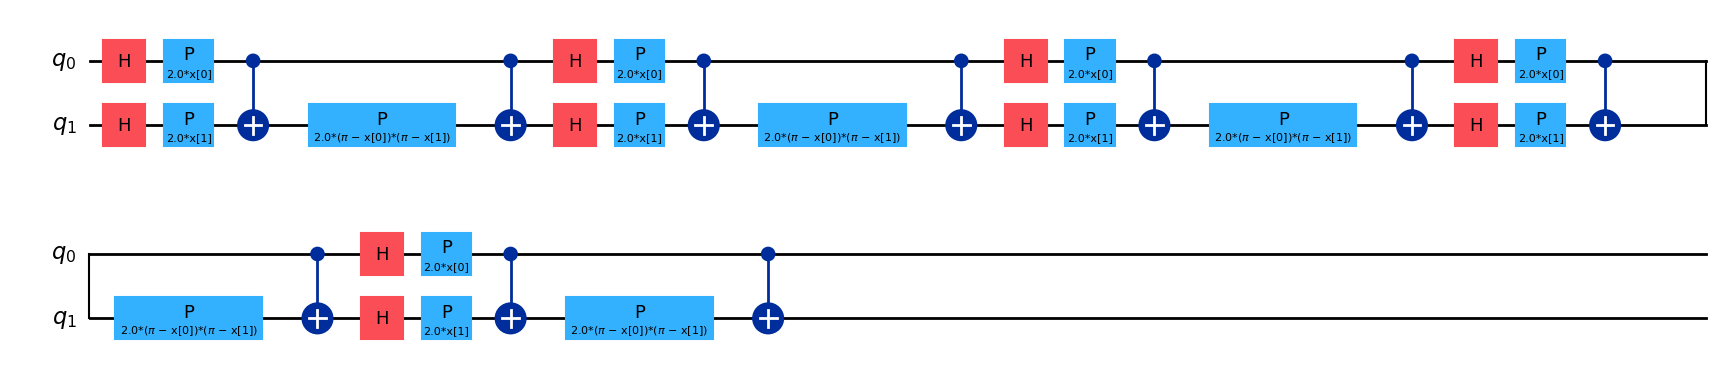

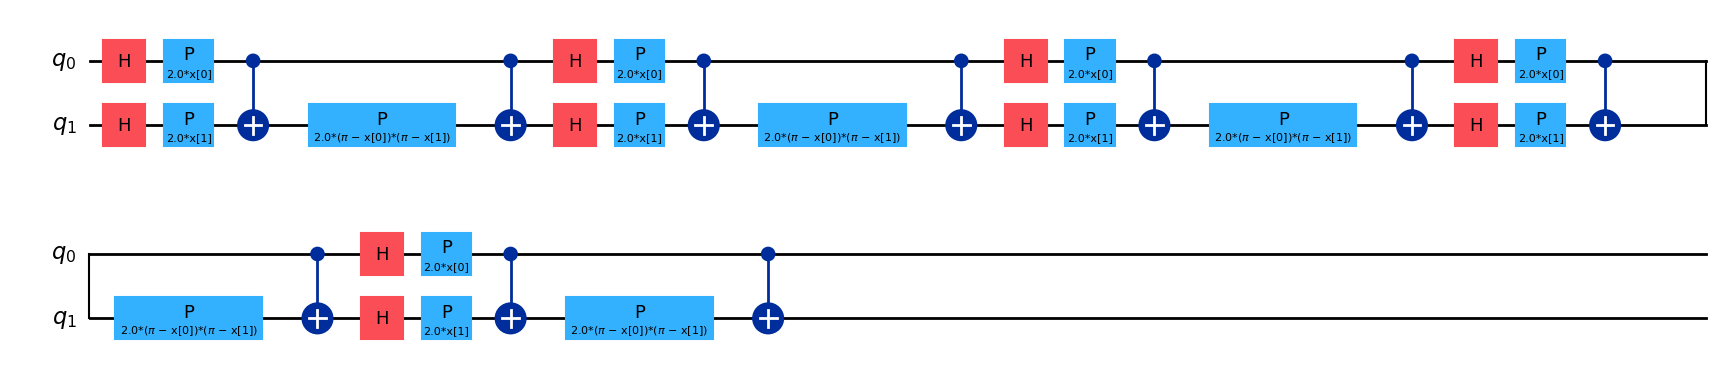

In [137]:
feature_dimension = 2 # number of features in X data

dataset_feature_map = ZZFeatureMap(
    feature_dimension=feature_dimension, 
    reps=5, 
    entanglement='full' # full / linear
)

sampler=Sampler()
fidelity=ComputeUncompute(sampler=sampler)

data_kernel=FidelityQuantumKernel(fidelity=fidelity, feature_map=dataset_feature_map) # definiowanie jądra kwantowego

circuit_drawer(dataset_feature_map.decompose(), output='mpl')

## Obliczanie macierzy jądra dla zbioru treningowego i testowego i wizualizacja

In [120]:
import matplotlib.pyplot as plt
import numpy as np

In [138]:
# WAŻNE - obliczanie macierzy wartości podobieństwa cech
%time
moon_matrix_train = data_kernel.evaluate(x_vec=X_train)
moon_matrix_test = data_kernel.evaluate(x_vec=X_test, y_vec=X_train)

CPU times: total: 0 ns
Wall time: 0 ns


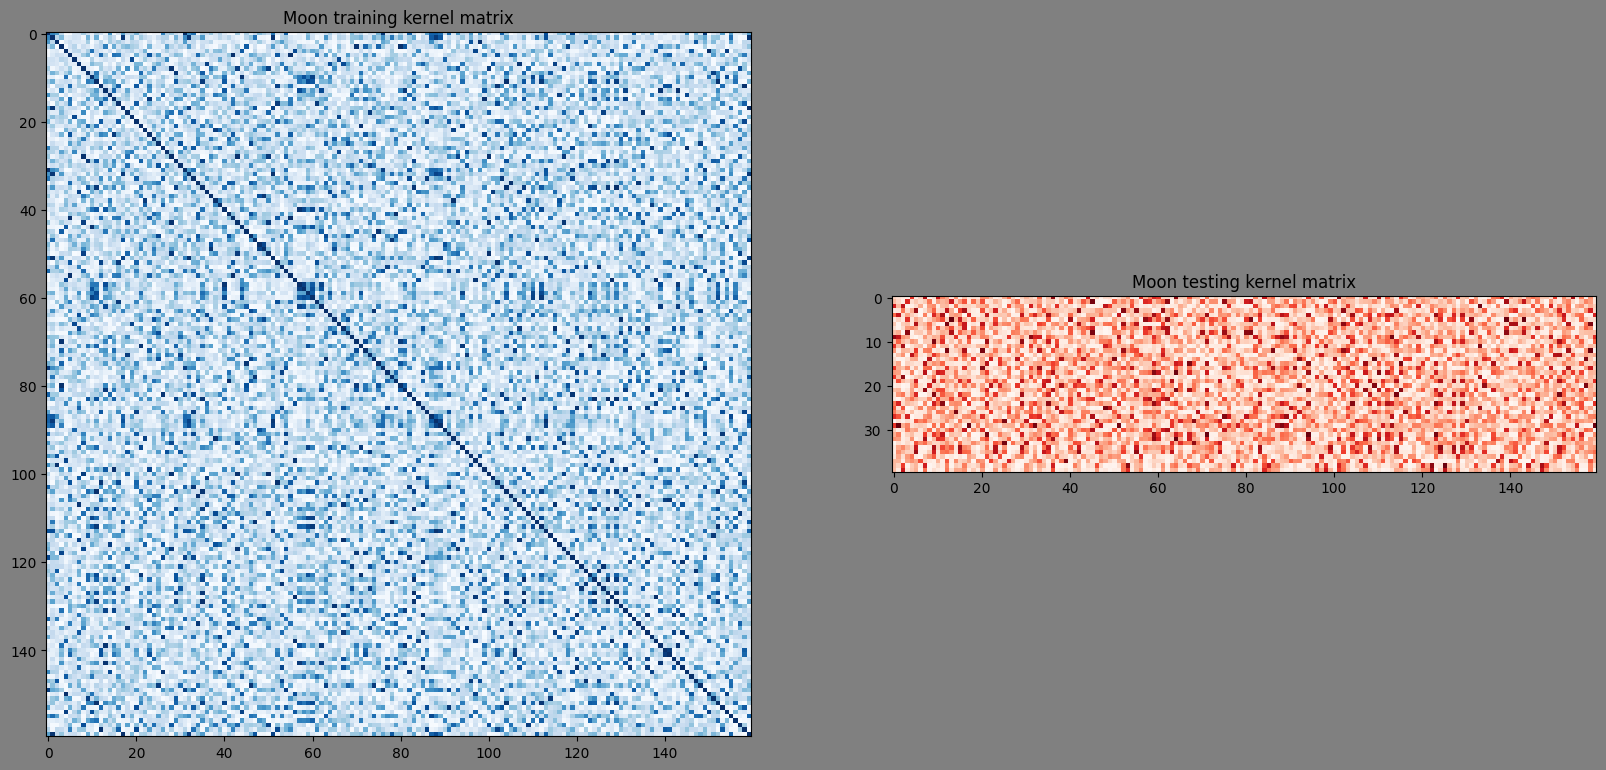

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), facecolor='grey')

axs[0].imshow(
    np.asmatrix(moon_matrix_train), 
    interpolation="nearest", 
    origin="upper", 
    cmap="Blues"
)
axs[0].set_title("Moon training kernel matrix")

axs[1].imshow(
    np.asmatrix(moon_matrix_test), 
    interpolation="nearest", 
    origin="upper", 
    cmap="Reds"
)
axs[1].set_title("Moon testing kernel matrix")

plt.show()

### Wyjaśnienie
#### `Moon training kernel matrix`
Wartości na osi $x$ i wartości na osi $y$ są takie same, a gradient kolorów pikseli reprezentje poziom podobieństwa ich wartości.

Kolor **granatowy** = *takie same*, kolor **biały** = *zupełnie różne*. 

Zgodnie z powyższym, piksele znajdujące się na współrzędnych $x=y$ są granatowe, ponieważ porównywane są te same wartości, w wyniku czego powstaje linia przekątna. 

#### `Moon testing kernel matrix`
Tutaj porównywane jest podobieństwo danych treningowych (oś $x$) z danymi testowymi (oś $y$)

In [ ]:
moon_matrix_short = data_kernel.evaluate(x_vec=X_train[:10])
moon_matrix_test_short = data_kernel.evaluate(x_vec=X_test[:5], y_vec=X_train[:10])

*Taka sama wizualizacja jak wyżej, tylko dla mniejszych (obciętych) danych*

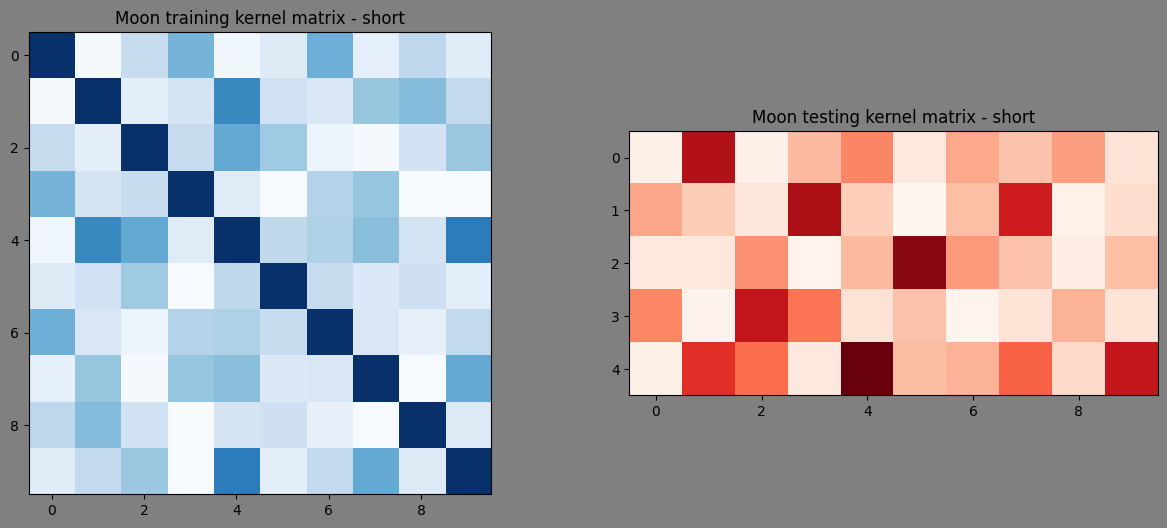

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), facecolor='grey')

axs[0].imshow(moon_matrix_short, cmap="Blues")
axs[0].set_title("Moon training kernel matrix - short")

axs[1].imshow(moon_matrix_test_short, cmap="Reds")
axs[1].set_title("Moon testing kernel matrix - short")
plt.show()

## Zadanie 3: Trening modelu SVM z prekomputowaną macierzą jądra
Po przygotowaniu macierzy jądra, można wytrenować klasyczny model SVM, używając tej macierzy zamiast klasycznych funkcji jądra. Będzie to nasza baza do porównania wyników z kwantowym SVM.

**Zadanie: Wytrenujcie model SVM z prekomputowaną macierzą jądra i oceńcie jego dokładność.**

In [153]:
import numpy as np
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions

moon_svc = SVC(kernel='precomputed')
moon_svc.fit(moon_matrix_train, y_train)
moon_score_precomputed_kernel = moon_svc.score(moon_matrix_test, y_test)

print(f"Precomputed kernel classification test score: {moon_score_precomputed_kernel*100}%")

Precomputed kernel classification test score: 57.49999999999999%


## Zadanie 4: Trening modelu QSVC
Teraz, gdy mamy macierz jądra kwantowego, możemy zastosować kwantową wersję algorytmu SVM, czyli QSVC, do klasyfikacji danych.

**Zadanie: Wytrenujcie model QSVC z użyciem kwantowego jądra i oceńcie jego dokładność.**

In [154]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=data_kernel)
qsvc.fit(X_train, y_train)
qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score*100}%")

QSVC classification test score: 0.575


## Zadanie 5: Wizualizacja granic decyzyjnych
Ostatnim krokiem będzie wizualizacja granic decyzyjnych uzyskanych przez model QSVC. Uczniowie będą mogli zobaczyć, jak model dzieli przestrzeń cech na różne klasy.

**Zadanie: Wizualizujcie granice decyzyjne modelu QSVC.**

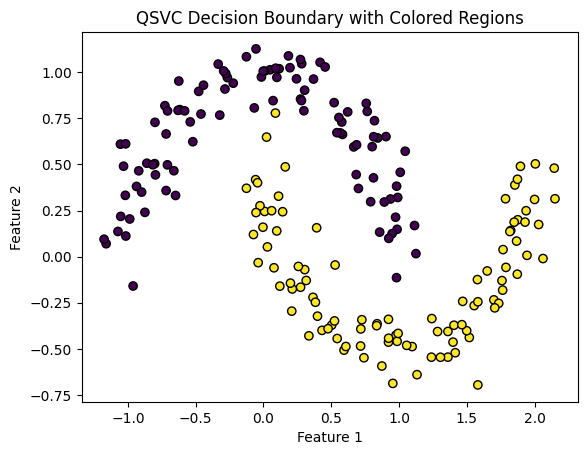

In [9]:
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
plt.title('QSVC Decision Boundary with Colored Regions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

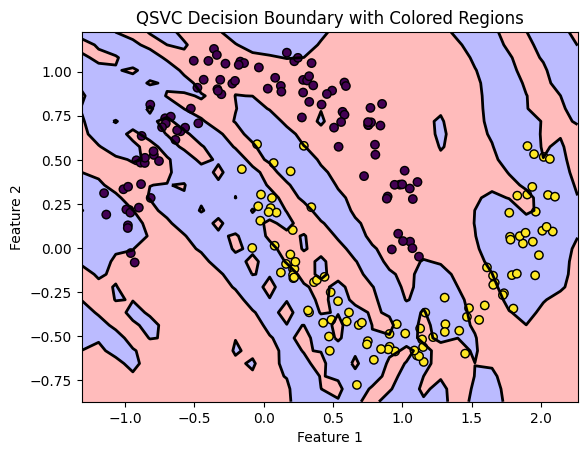

In [38]:
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = qsvc.decision_function(xy).reshape(XX.shape)

ax.contourf(XX, YY, Z, levels=[Z.min(), 0, Z.max()], colors=['#FFAAAA', '#AAAAFF'], alpha=0.8)
ax.contour(XX, YY, Z, colors='k', levels=[0], linewidths=2)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
plt.title('QSVC Decision Boundary with Colored Regions')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Podsumowanie:
W tym zadaniu nauczyliście się, jak trenować klasyczne i kwantowe modele SVM.
Porównaliście dokładność klasycznego modelu SVM z kwantowym modelem QSVC.
Zobaczyliście, jak można używać kwantowych komputerów do rozwiązywania problemów klasyfikacji.